In [1]:
import pandas as pd
import pathlib
import numpy as np
import json
import re
from matplotlib import pyplot
from tqdm import tqdm
import itertools
from collections import Counter

In [2]:
import tensorflow as tf 
tf.__version__

'2.1.0-rc1'

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## Import des données depuis un fichier csv obtenu par le notebook de Lorenzo

### Ce fichier contient 
##### - Les examens d’une durée supérieure à 2min30s
##### - Les examens ne présentant pas trop de valeurs « vide » (< 9%)
##### - Les patients qui présentent au moins 50 secondes de crise sur l’ensemble de leurs enregistrements
##### - Que les 15 meilleures features (cf Notebook sur la selection des features)

In [5]:
df_xqrs = pd.read_csv("./xqrs_filtered.csv")

In [6]:
# génération du champ patient
df_xqrs['Patient'] = df_xqrs['Key'].str.split("_",expand=True)[4]

## Nettoyage des donnéees et selection du patient

In [7]:
#suppression des lignes où le label est vide
df_xqrs.dropna(subset=['label'],inplace=True)

In [8]:
#remplacement des valeurs de label par 1 si c'est différent de 0
df_xqrs['label']= df_xqrs['label'].apply(lambda x: 0 if (x==0) else 1)

In [9]:
patient_kept = ['10418']

#'7793', '6904', '7584', '4456', '11333', '11870', '11869', '9540','2806', '12941', '12973', '10843', '2991', '7032', '12759', '6546',
#'6514', '10418', '6175', '11077', '2521', '9842', '9885', '6444','6440', '9630', 'a', '7623', '5452', '5034', '3977', '473', '6083',
#'3401', '302', '6507', '7252', '7234', '2760', '7835', '1324','2448', '2484', '3668', '7128', '6413', '8544', '10106', '9578',
#'8460', '9866', '675', '1770', '5943', '258', '4151', '5625'

In [10]:
#filtrage sur le(s) patient(s)
df_xqrs=df_xqrs[df_xqrs['Patient'].isin(patient_kept)]

In [11]:
#remplacement des valeurs "inf" par Nan
df_xqrs = df_xqrs.replace([np.inf, -np.inf], np.nan)

In [12]:
# remplacement des valeurs "Nan" par la moyenne de l'examen

df_xqrs2 = df_xqrs.groupby(df_xqrs['Key']).transform(lambda x: x.fillna(x.mean()))

In [13]:
#on remet la clé qui a disparu au moment du groupby
df_xqrs2['Key'] = df_xqrs['Key'].values

In [14]:
#definition d'une fonction pour transformer les series temporelles:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in df.columns]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in df.columns]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in df.columns]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg = agg.iloc[n_in:,]
    return agg

In [15]:
#definition d'une variable qui indique le nombre de périodes que nous allons prendre en compte
nb_period = 6

In [16]:
# creation d'un dataframe où les series sont temporalisée examen par examen
df_xqrs_temp = pd.DataFrame()

for i in df_xqrs.Key.unique():
    df_xqrs_temp = pd.concat([df_xqrs_temp,series_to_supervised(df_xqrs2[df_xqrs2['Key']== i],nb_period,1)])

## Liste des dropped_columns/ features avec les 15 meilleures variables

In [17]:
features_non_temp =['Key']

numerical_feat = ['mean_nni','median_nni','mean_hr','max_hr','min_hr',
                  'lf','hf','vlf','lf_hf_ratio',
                  'csi','cvi','Modified_csi','sd1','sd2','sampen']

categorical_feat = ['Patient']
features_temp = numerical_feat+categorical_feat

In [18]:
# constitution de la liste des features qui rajoute les (t-n)

features_list = ['%s(t-%d)' % (i,j) for i in features_temp for j in range(1,nb_period+1)]
features_list +=  ['%s(t)' % i for i in features_temp]
features_list +=  ['%s(t)' % i for i in features_non_temp]
features_list = sorted(features_list)
target_variable = "label(t)"

X = df_xqrs_temp.loc[:,features_list]
Y = df_xqrs_temp.loc[:,target_variable]

In [19]:
## split test/train

# surtout ne pas faire de split train/test avec un random et un stratify, cela fausse les résultats car on inclue des données du test dans le train
#X_train, X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state =42, stratify = Y)

train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
X_train, X_test = X.iloc[0:train_size], X.iloc[train_size:len(X)]
Y_train, Y_test = Y.iloc[0:train_size], Y.iloc[train_size:len(X)]
print(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape)

(1281, 113) (321, 113) (1281,) (321,)


In [20]:
# calculate basic figures to share ours results
print("nb exams sur le train: ",X_train['Key(t)'].unique().shape[0])
print("nb exams sur le test: ",X_test['Key(t)'].unique().shape[0])
print("nb lignes sur le train: ",X_train.shape[0])
print("nb lignes sur le test: ",X_test.shape[0])

nb exams sur le train:  25
nb exams sur le test:  3
nb lignes sur le train:  1281
nb lignes sur le test:  321


In [21]:
#drop "cle_exam" (je la gardais pour pouvoir calculer le nb d'exams et de lignes juste avant)
cle_exam_list = ['Key(t)']

X_train = X_train.drop(cle_exam_list,axis=1)
X_test = X_test.drop(cle_exam_list,axis=1)

In [22]:
def my_normalisation_ecoding(X_train, X_test, numeric_feat, categoric_feat, nb_t):

    # Normalization
    numeric_transformer = StandardScaler()
    # OHE / dummyfication
    categorical_indices =[X_train.columns.get_loc('%s(t-%d)' %  (i,j)) for i in categoric_feat for j in range(1,nb_t+1)]
    categorical_indices += [X_train.columns.get_loc('%s(t)' %  i) for i in categoric_feat]
    categorical_indices = sorted(categorical_indices)

    numeric_indices =[X_train.columns.get_loc('%s(t-%d)' %  (i,j)) for i in numeric_feat for j in range(1,nb_t+1)]
    numeric_indices += [X_train.columns.get_loc('%s(t)' %  i) for i in numeric_feat]
    numeric_indices = sorted(numeric_indices)


    categorical_transformer = OneHotEncoder(drop='first')

    featureencoder = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_indices),    
            ('num', numeric_transformer, numeric_indices)
            ]
        )

    X_train_fit = featureencoder.fit_transform(X_train)
    X_test_fit = featureencoder.transform(X_test)
    return X_train_fit, X_test_fit

# Entrainement d'un Decision Tree

In [23]:
classifier = DecisionTreeClassifier()

In [ ]:
classifier.fit(X_train_fit,Y_train)

In [ ]:
Y_train_pred = classifier.predict(X_train_fit)
Y_test_pred = classifier.predict(X_test_fit)

In [ ]:
print("Accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

In [ ]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

In [ ]:
print("recall score on train set : ", recall_score(Y_train,Y_train_pred))
print("recall score on test set : ", recall_score(Y_test,Y_test_pred))

In [ ]:
print("precision score on train set : ", precision_score(Y_train,Y_train_pred))
print("precision score on test set : ", precision_score(Y_test,Y_test_pred))

In [ ]:
print("f1 score on train set : ", f1_score(Y_train,Y_train_pred))
print("f1 score on test set : ", f1_score(Y_test, Y_test_pred))

In [ ]:
print("Classification Report Train")
print(classification_report(Y_train,Y_train_pred))

In [ ]:
print("Classification Report Test")
print(classification_report(Y_test,Y_test_pred))

# Entrainement d'un LSTM

In [25]:
X_train_fit,X_test_fit = my_normalisation_ecoding(X_train, X_test,numerical_feat, categorical_feat, nb_period)

In [26]:
#reshape specifique en 3D pour le format attendu pour le LSTM

param2 =int(X_train_fit.shape[1]/(nb_period+1))

X_train_resh = X_train_fit.reshape((X_train_fit.shape[0],nb_period+1,param2))
X_test_resh = X_test_fit.reshape((X_test_fit.shape[0], nb_period+1, param2))
#print(X_train_resh.shape, Y_train.shape, X_test_resh.shape, Y_test.shape)

In [27]:
# design network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(600, input_shape=(X_train_resh.shape[1], X_train_resh.shape[2])))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600)               1478400   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 1,479,001
Trainable params: 1,479,001
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1090,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryCrossentropy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [30]:
# fit network
history = model.fit(X_train_resh, Y_train, epochs=100, batch_size=36, validation_data=(X_test_resh, Y_test), verbose=2, shuffle=False)


Train on 1281 samples, validate on 321 samples
Epoch 1/100
1281/1281 - 3s - loss: 0.6843 - binary_crossentropy: 0.6843 - precision: 0.0315 - recall: 0.0545 - val_loss: 0.4066 - val_binary_crossentropy: 0.4066 - val_precision: 0.4746 - val_recall: 0.8235
Epoch 2/100
1281/1281 - 2s - loss: 0.4858 - binary_crossentropy: 0.4858 - precision: 0.0392 - recall: 0.0364 - val_loss: 0.3294 - val_binary_crossentropy: 0.3294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
1281/1281 - 2s - loss: 0.4277 - binary_crossentropy: 0.4277 - precision: 0.0588 - recall: 0.0303 - val_loss: 0.2348 - val_binary_crossentropy: 0.2348 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
1281/1281 - 2s - loss: 0.3781 - binary_crossentropy: 0.3781 - precision: 0.2778 - recall: 0.0606 - val_loss: 0.2011 - val_binary_crossentropy: 0.2011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
1281/1281 - 2s - loss: 0.3286 - binary_crossentropy: 0.3286 - precision: 0.1930 - recall:

Epoch 40/100
1281/1281 - 2s - loss: 0.0788 - binary_crossentropy: 0.0788 - precision: 0.8848 - recall: 0.8848 - val_loss: 0.6958 - val_binary_crossentropy: 0.6958 - val_precision: 0.2348 - val_recall: 0.7941
Epoch 41/100
1281/1281 - 2s - loss: 0.0753 - binary_crossentropy: 0.0753 - precision: 0.8889 - recall: 0.8242 - val_loss: 0.6691 - val_binary_crossentropy: 0.6691 - val_precision: 0.2456 - val_recall: 0.8235
Epoch 42/100
1281/1281 - 2s - loss: 0.1055 - binary_crossentropy: 0.1055 - precision: 0.8588 - recall: 0.8848 - val_loss: 0.6082 - val_binary_crossentropy: 0.6082 - val_precision: 0.2308 - val_recall: 0.7059
Epoch 43/100
1281/1281 - 2s - loss: 0.0780 - binary_crossentropy: 0.0780 - precision: 0.9226 - recall: 0.8667 - val_loss: 0.6388 - val_binary_crossentropy: 0.6388 - val_precision: 0.2549 - val_recall: 0.7647
Epoch 44/100
1281/1281 - 2s - loss: 0.0627 - binary_crossentropy: 0.0627 - precision: 0.9308 - recall: 0.8970 - val_loss: 0.7592 - val_binary_crossentropy: 0.7592 - val

Epoch 80/100
1281/1281 - 2s - loss: 0.0217 - binary_crossentropy: 0.0217 - precision: 0.9936 - recall: 0.9455 - val_loss: 0.9384 - val_binary_crossentropy: 0.9384 - val_precision: 0.2574 - val_recall: 0.7647
Epoch 81/100
1281/1281 - 2s - loss: 0.0241 - binary_crossentropy: 0.0241 - precision: 0.9641 - recall: 0.9758 - val_loss: 0.8909 - val_binary_crossentropy: 0.8909 - val_precision: 0.2688 - val_recall: 0.7353
Epoch 82/100
1281/1281 - 2s - loss: 0.0238 - binary_crossentropy: 0.0238 - precision: 1.0000 - recall: 0.9515 - val_loss: 0.9684 - val_binary_crossentropy: 0.9684 - val_precision: 0.2673 - val_recall: 0.7941
Epoch 83/100
1281/1281 - 2s - loss: 0.0230 - binary_crossentropy: 0.0230 - precision: 0.9477 - recall: 0.9879 - val_loss: 0.7565 - val_binary_crossentropy: 0.7565 - val_precision: 0.3000 - val_recall: 0.7941
Epoch 84/100
1281/1281 - 2s - loss: 0.0217 - binary_crossentropy: 0.0217 - precision: 0.9876 - recall: 0.9636 - val_loss: 0.9455 - val_binary_crossentropy: 0.9455 - val

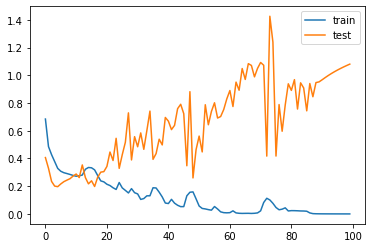

In [31]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
Y_train_pred2 = model.predict_classes(X_train_resh)
Y_test_pred2 = model.predict_classes(X_test_resh)

In [33]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train,Y_train_pred2))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred2))
print()

Confusion matrix on train set : 
[[1116    0]
 [   0  165]]

Confusion matrix on test set : 
[[216  71]
 [  5  29]]



In [34]:
print("Classification Report Train")
print(classification_report(Y_train,Y_train_pred2))

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1116
           1       1.00      1.00      1.00       165

    accuracy                           1.00      1281
   macro avg       1.00      1.00      1.00      1281
weighted avg       1.00      1.00      1.00      1281



In [35]:
print("Classification Report Test")
print(classification_report(Y_test,Y_test_pred2))

Classification Report Test
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       287
           1       0.29      0.85      0.43        34

    accuracy                           0.76       321
   macro avg       0.63      0.80      0.64       321
weighted avg       0.90      0.76      0.81       321



# Entrainement de XGBoost

In [ ]:
from functions import test_sk_models
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier


#### Normalisation et encoding

In [36]:
X_train_fit,X_test_fit = my_normalisation_ecoding(X_train, X_test,numerical_feat, categorical_feat, nb_period)

#### Définition du modèle

In [37]:
my_boost = XGBClassifier()

In [38]:
my_boost = XGBClassifier(n_jobs=8,verbosity=2,learning_rate=0.5,max_depth=10,n_estimators=500)

In [39]:
my_boost.fit(X_train_fit,Y_train)

[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=9
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=10
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=10
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 prun

[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes

[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:44] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=2)

In [40]:
params = {'max_depth': [8,12],
         'n_estimators': [1000,2000]}

In [41]:
best_xgboost = GridSearchCV(my_boost,params)
best_xgboost.fit(X_train_fit,Y_train)

[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=7
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=7
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned

[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:52] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:53] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes

[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:54] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:55] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned

[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:56] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:57] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=7
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned

[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:58] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:01:59] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes

[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:00] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes

[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:01] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nod

[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:03] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes

[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:04] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned

[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:05] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=4
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 12 extra nodes, 0 pruned

[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:06] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=7
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=7
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=7
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=7
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned

[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:07] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 6 extra nodes, 0 pruned node

[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:08] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:09] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 14 extra nodes, 0 pruned

[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:11] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes

[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=7
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=7
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned

[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:13] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:14] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned

[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:15] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes

[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned

[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:16] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:02:17] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 2 extra nodes, 0 pruned nodes

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.5, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=8,
                                     num_parallel_tree=1,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method=N

In [42]:
best_xgboost.best_params_

{'max_depth': 8, 'n_estimators': 1000}

##### Calcul des predictions et des scores pour XGBoost 

In [43]:
Y_train_pred3 = my_boost.predict(X_train_fit)
Y_test_pred3 = my_boost.predict(X_test_fit)

In [44]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train,Y_train_pred3))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred3))
print()

Confusion matrix on train set : 
[[1116    0]
 [   0  165]]

Confusion matrix on test set : 
[[233  54]
 [  8  26]]



In [45]:
print("Classification Report Train")
print(classification_report(Y_train,Y_train_pred3))

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1116
           1       1.00      1.00      1.00       165

    accuracy                           1.00      1281
   macro avg       1.00      1.00      1.00      1281
weighted avg       1.00      1.00      1.00      1281



In [46]:
print("Classification Report Test")
print(classification_report(Y_test,Y_test_pred3))

Classification Report Test
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       287
           1       0.33      0.76      0.46        34

    accuracy                           0.81       321
   macro avg       0.65      0.79      0.67       321
weighted avg       0.90      0.81      0.84       321

